# Running and viewing results

This is a quick and easy way to run and debug my predictions.

In [1]:
import json
import get_predict
from pathlib import Path
from PIL import Image, ImageOps
import pandas as pd
import matplotlib.pyplot as plt

IMG_HEIGHT = 1024
IMG_WIDTH = 1024

2023-12-03 11:49:12.371863: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 11:49:12.371910: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 11:49:12.371929: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 11:49:12.378954: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### On-off test
For validation, I modify this code to quicky get a single prediction.

In [ ]:
images = [
    Path("tmp/morgan_freeman-wikipedia.jpg"),
    Path("tmp/burt_reynolds-wikipedia.jpg"),
    Path("tmp/asian_woman-openjourney-v4.jpg"),
    Path("tmp/me_person-stabilityai-SD-XL-1.0.jpg"),
    Path("tmp/latinx_person-dalle-mini.jpg"),
    Path("tmp/me.jpg"),
    Path("tmp/litmus_real.png"),
    Path("tmp/litmus_synthetic.jpg"),
]

data = get_predict.prediction(images=images)

pd.DataFrame.from_dict(data, orient="index")

# Generating synthetics

Generative prompt:

* https://clipdrop.co/stable-diffusion-turbo -- all genders
* https://huggingface.co/spaces/google/sdxl -- person, but 4 options provided (all loaded)

```
{race} {gender} looking directly at the camera for a professional headshot using a Sony A7 III camera with1/250, f/1.4, ISO 200 – FE 35mm 1.4 ZA – Portrait Style and 6200˚K
```

Supplied **`genders`**:

* woman
* man
* person

Supplied **`races`**:

* Asian
* African
* Black
* White
* Latinx
* Middle Eastern
* Native American

Without knowing the training set categorization, I can only speculate on some of the racial categorizations -- in whether they identified a difference between _black_ (as in the skin color) and _African_ (as in race as a native-born characteristic to a geographical region). 

In [ ]:
races = [
    "Asian",
    "African",
    "Black",
    "White",
    "Latinx",
    "Middle Eastern",
    "Native American",
]
genders = ["man", "woman", "person"]

combined = []
for race in races:
    [combined.append((race, gender)) for gender in genders]

print(f"Generating {len(combined)} prompts.")
for race, gender in combined:
    print(
        f"{race} {gender} looking directly at the camera for a professional headshot taken using a Sony A7 III camera with1/250, f/1.4, ISO 200 – FE 35mm 1.4 ZA – Portrait Style and 6200˚K"
    )

## Pre-check

In [ ]:
src_folder = "tmp"
images = [x for x in Path(src_folder).rglob("*.jpg")]

print(f"Found {len(images)} images to check.")

for img in images:
    image = Image.open(img)
    print(f"{img.name}")
    print(f"\t{image.mode=}")
    if image.mode != "RGB":
        image = image.convert("RGB")
        image.save(f"{src_folder}/{img.stem}.jpg")

        print(f"\tConverted to {image.mode=}")
        print(f"\tSaved to {src_folder}/{img.stem}.jpg")

    print(f"\tStarting dimensions: {image.height}x{image.width}")
    # Make square from largest number
    smaller_dim = image.width if image.width <= image.height else image.height

    # Make no changes to "square-ness" unless we need to
    if smaller_dim != (image.width + image.height) / 2:
        left = int(image.width - smaller_dim) / 2
        top = int(image.height - smaller_dim) / 2
        right = left
        bottom = top

        squared = ImageOps.crop(
            image,
            border=(
                left,
                top,
                right,
                bottom,
            ),
        )

        print(f"\t{smaller_dim=}")
        print(f"\tTrim borders = {left=}, {top=}, {right=}, {bottom=}")
        print(f"\tSquared to: {squared.height}x{squared.width}")

    else:
        squared = image

    # Zoom to desired pixels
    result = squared.resize((IMG_HEIGHT, IMG_WIDTH))
    print(f"\tFinal dimensions: {result.height}x{result.width}")

    # Uncomment to overwrite
    result.save(f"{src_folder}/{img.stem}.jpg")
    print(f"\tSaved to {src_folder}/{img.stem}.jpg")

# Run
This _can_ run fine on a consumer device. The more images scanned the more this process benefits from utilzing an HPC job since it is CPU heavy.

In [ ]:
images = [x for x in Path("predict").rglob("*.jpg")]
print(f"Found {len(images)} images to predict.")
prediction_results = get_predict.prediction(images=images)


with open("reports/predictions.json", "w+") as f:
    json.dump(prediction_results, f)

# Analyze

In [3]:
data = pd.read_json(open("reports/predictions.json", "r"), orient="index")

<Axes: >

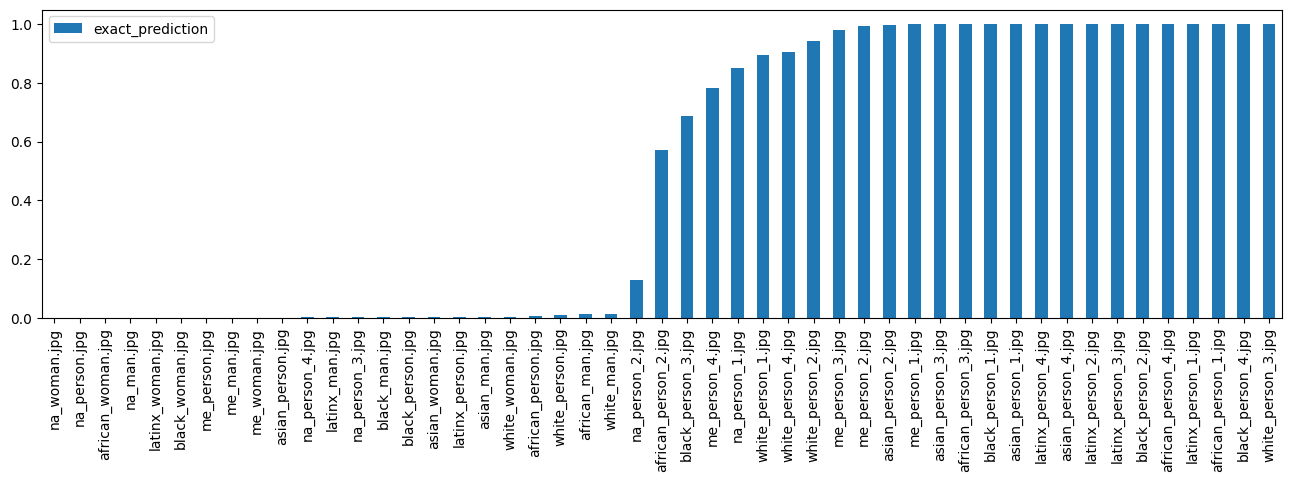

In [4]:
selected = data.sort_values(by=["exact_prediction"])
selected.plot.bar(y="exact_prediction", figsize=(16, 4))

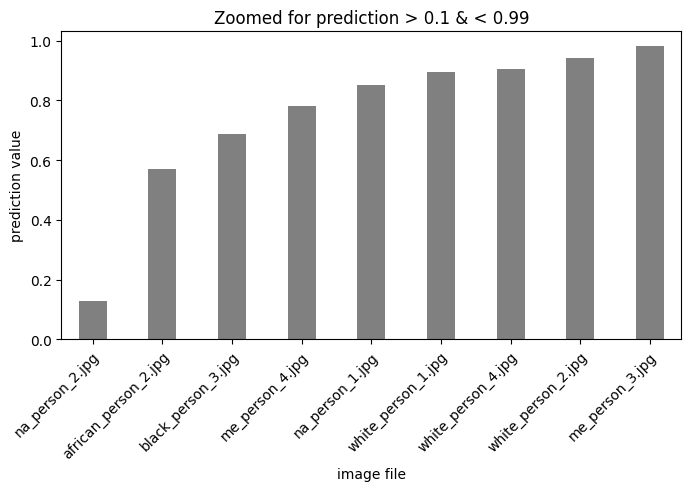

In [5]:
zoom_selected = selected[
    (selected.exact_prediction > 0.1) & (selected.exact_prediction < 0.99)
]
zoom_selected_ax = zoom_selected.plot.bar(
    y="exact_prediction", figsize=(8, 4), color="gray", width=0.4, legend=False
)
zoom_selected_ax.set_title("Zoomed for prediction > 0.1 & < 0.99")
zoom_selected_ax.set_xlabel("image file")
zoom_selected_ax.set_ylabel("prediction value")
zoom_selected_bar = plt.setp(zoom_selected_ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

In [12]:
plt.rcParams['text.usetex'] = True

selected_fig = plt.figure()
selected_ax = selected_fig.add_subplot(1, 1, 1)
selected_ax.spines['bottom'].set_position('center')
selected_ax.spines['right'].set_color('none')
selected_ax.spines['top'].set_color('none')
selected_ax.set_ylabel('prediction result')
selected_ax.set_yticks([0,0.5,1])
selected_ax.set_yticklabels(['synthetic','0,5','real'])
selected_ax.set_xlabel('image count')
plt.plot(range(0,49), selected.exact_prediction, label="accuracy", c='pink',linestyle="",marker="o")
plt.show()


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>